<a href="https://colab.research.google.com/github/jblackM1/AAI_590-Capstone-Project/blob/main/AAI_590_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/rules

# Libraries and Setup

In [1]:
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 52.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import dask.dataframe as dd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [44]:
#@title Kaggle Json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jenniferkblack","key":"741f96f6b3af092ec0f806e689a2e3fd"}'}

In [45]:
#@title Install Kaggle

! pip install kaggle

In [46]:
#@title Configure Kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Data Loading (H&M Data Setup)

In [ ]:
#@title Download Data - H&M

!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

In [ ]:
#@title Unzip files

! unzip -n /content/h-and-m-personalized-fashion-recommendations.zip -d /content/drive/MyDrive/h-and-m-personalized-fashion-recommendations


## Data Loading (Product Reviews)

In [47]:
#@title Download Data - Product Reviews

!kaggle datasets download -d nicapotato/womens-ecommerce-clothing-reviews

  0% 0.00/2.79M [00:00<?, ?B/s]
100% 2.79M/2.79M [00:00<00:00, 165MB/s]


In [48]:
#@title Unzip files

! unzip -n /content/womens-ecommerce-clothing-reviews.zip -d /content/drive/MyDrive/womens-ecommerce-clothing-reviews

Archive:  /content/womens-ecommerce-clothing-reviews.zip


# Data Setup

In [4]:
#@title Load H&M Transactions data
file_path = '/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/transactions_train.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [5]:
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [6]:
len(df)

31788324

In [7]:
df.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [8]:
# Convert the 't_dat' column to datetime format
df['t_dat'] = pd.to_datetime(df['t_dat'])
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [9]:
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                   int64
price                      float64
sales_channel_id             int64
dtype: object

In [10]:
#@title Load H&M Articles data
file_path = '/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/articles.csv'

# Read the CSV file into a DataFrame
df_article_info = pd.read_csv(file_path)

In [11]:
df_article_info.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

In [49]:
#@title Load Product Review data
# Replace the file path with your actual file path
file_path = '/content/drive/MyDrive/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv'

# Read the CSV file into a DataFrame
df_product_reviews = pd.read_csv(file_path)

In [51]:
df_product_reviews.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


from matplotlib import pyplot as plt
_df_0['Unnamed: 0'].plot(kind='hist', bins=20, title='Unnamed: 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Clothing ID'].plot(kind='hist', bins=20, title='Clothing ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Rating'].plot(kind='hist', bins=20, title='Rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Division Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Department Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('Class Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Unnamed: 0', y='Clothing ID', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Clothing ID', y='Age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='Age', y='Rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='Rating', y='Recommended IND', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Unnamed: 0']
  ys = series['Clothing ID']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Division Name')):
  _plot_series(series, series_name, i)
  fig.legend(title='Division Name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('Clothing ID')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Unnamed: 0']
  ys = series['Clothing ID']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Department Name')):
  _plot_series(series, series_name, i)
  fig.legend(title='Department Name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('Clothing ID')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Unnamed: 0']
  ys = series['Clothing ID']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Class Name')):
  _plot_series(series, series_name, i)
  fig.legend(title='Class Name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('Clothing ID')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Unnamed: 0']
  ys = series['Age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('Unnamed: 0', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Division Name')):
  _plot_series(series, series_name, i)
  fig.legend(title='Division Name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('Age')

from matplotlib import pyplot as plt
_df_15['Unnamed: 0'].plot(kind='line', figsize=(8, 4), title='Unnamed: 0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Clothing ID'].plot(kind='line', figsize=(8, 4), title='Clothing ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['Rating'].plot(kind='line', figsize=(8, 4), title='Rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Department Name'].value_counts()
    for x_label, grp in _df_19.groupby('Division Name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Division Name')
_ = plt.ylabel('Department Name')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Class Name'].value_counts()
    for x_label, grp in _df_20.groupby('Department Name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Department Name')
_ = plt.ylabel('Class Name')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['Division Name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='Unnamed: 0', y='Division Name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['Department Name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='Unnamed: 0', y='Department Name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['Class Name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='Unnamed: 0', y='Class Name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['Division Name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='Clothing ID', y='Division Name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Feature Engineering

In [ ]:
num_transactions = len(df)
print(num_transactions)

start_date = df['t_dat'].min()
end_date = df['t_dat'].max()

print(f"Time frame of transactions: {start_date} to {end_date}")

31788324
Time frame of transactions: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


In [12]:
# Merge data frames
ddf = dd.merge(df, df_article_info, on='article_id', how='inner')

# If 'df' and 'df_article_info' are pandas DataFrames, you can convert them to Dask DataFrames:
ddf = dd.from_pandas(df, npartitions=10)  # You can adjust the number of partitions

# Perform the merge operation
merged_ddf = dd.merge(ddf, df_article_info, on='article_id', how='inner')

# Compute the result into a Pandas DataFrame
merged_df = merged_ddf.compute()

In [13]:
merged_df.dtypes

t_dat                           datetime64[ns]
customer_id                             object
article_id                               int64
price                                  float64
sales_channel_id                         int64
product_code                             int64
prod_name                               object
product_type_no                          int64
product_type_name                       object
product_group_name                      object
graphical_appearance_no                  int64
graphical_appearance_name               object
colour_group_code                        int64
colour_group_name                       object
perceived_colour_value_id                int64
perceived_colour_value_name             object
perceived_colour_master_id               int64
perceived_colour_master_name            object
department_no                            int64
department_name                         object
index_code                              object
index_name   

# EDA

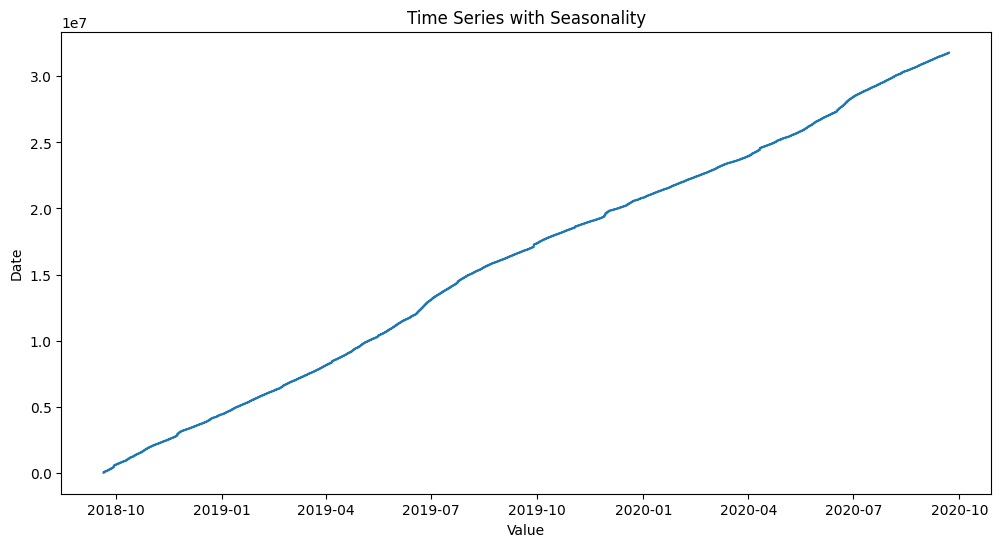

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['t_dat'],df.index)
plt.title('Time Series')
plt.ylabel('Date')
plt.xlabel('Value')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='t_dat', y='value', hue='product_category', data=grouped_df)
plt.title('Time Series Data by Product Category')
plt.xlabel('Date')
plt.ylabel('Aggregated Value')
plt.show()

In [ ]:
merged_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,663713001,0.049475,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
2,2018-09-20,4ef5967ff17bf474bffebe5b16bd54878e1d4105f7b4ed...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
3,2018-09-20,6b7b10d2d47516c82a6f97332478dab748070f09693f09...,663713001,0.050831,1,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
4,2018-09-20,8ac137752bbe914aa4ae6ad007a9a0c5b67a1ab2b2d474...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."


from matplotlib import pyplot as plt
_df_0['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['sales_channel_id'].plot(kind='hist', bins=20, title='sales_channel_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('customer_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='price', y='sales_channel_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['article_id']
  ys = series['price']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('article_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('article_id')
_ = plt.ylabel('price')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['article_id']
  ys = series['sales_channel_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('article_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('article_id')
_ = plt.ylabel('sales_channel_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['article_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'article_id'}, axis=1)
              .sort_values('article_id', ascending=True))
  xs = counted['article_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('article_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('article_id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['product_code']
  ys = series['price']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('product_code', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('product_code')
_ = plt.ylabel('price')

from matplotlib import pyplot as plt
_df_8['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['sales_channel_id'].plot(kind='line', figsize=(8, 4), title='sales_channel_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['customer_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='price', y='customer_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['customer_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='sales_channel_id', y='customer_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
merged_df.dtypes

t_dat                           datetime64[ns]
customer_id                             object
article_id                               int64
price                                  float64
sales_channel_id                         int64
product_code                             int64
prod_name                               object
product_type_no                          int64
product_type_name                       object
product_group_name                      object
graphical_appearance_no                  int64
graphical_appearance_name               object
colour_group_code                        int64
colour_group_name                       object
perceived_colour_value_id                int64
perceived_colour_value_name             object
perceived_colour_master_id               int64
perceived_colour_master_name            object
department_no                            int64
department_name                         object
index_code                              object
index_name   

In [ ]:
print(merged_df.describe())

         article_id         price  sales_channel_id  product_code  \
count  3.178832e+07  3.178832e+07      3.178832e+07  3.178832e+07   
mean   6.962272e+08  2.782927e-02      1.704028e+00  6.962272e+05   
std    1.334480e+08  1.918113e-02      4.564786e-01  1.334480e+05   
min    1.087750e+08  1.694915e-05      1.000000e+00  1.087750e+05   
25%    6.328030e+08  1.581356e-02      1.000000e+00  6.328030e+05   
50%    7.145820e+08  2.540678e-02      2.000000e+00  7.145820e+05   
75%    7.865240e+08  3.388136e-02      2.000000e+00  7.865240e+05   
max    9.562170e+08  5.915254e-01      2.000000e+00  9.562170e+05   

       product_type_no  graphical_appearance_no  colour_group_code  \
count     3.178832e+07             3.178832e+07       3.178832e+07   
mean      2.462434e+02             1.009727e+06       2.631858e+01   
std       6.779323e+01             1.701311e+04       2.620701e+01   
min      -1.000000e+00            -1.000000e+00      -1.000000e+00   
25%       2.530000e+02      

In [ ]:
print(merged_df.isnull().sum())

t_dat                                0
customer_id                          0
article_id                           0
price                                0
sales_channel_id                     0
product_code                         0
prod_name                            0
product_type_no                      0
product_type_name                    0
product_group_name                   0
graphical_appearance_no              0
graphical_appearance_name            0
colour_group_code                    0
colour_group_name                    0
perceived_colour_value_id            0
perceived_colour_value_name          0
perceived_colour_master_id           0
perceived_colour_master_name         0
department_no                        0
department_name                      0
index_code                           0
index_name                           0
index_group_no                       0
index_group_name                     0
section_no                           0
section_name             

In [ ]:
num_garment_groups = df_article_info['garment_group_name'].nunique()

print(f"Number of Garment Groups: {num_garment_groups}")

Number of Garment Groups: 21


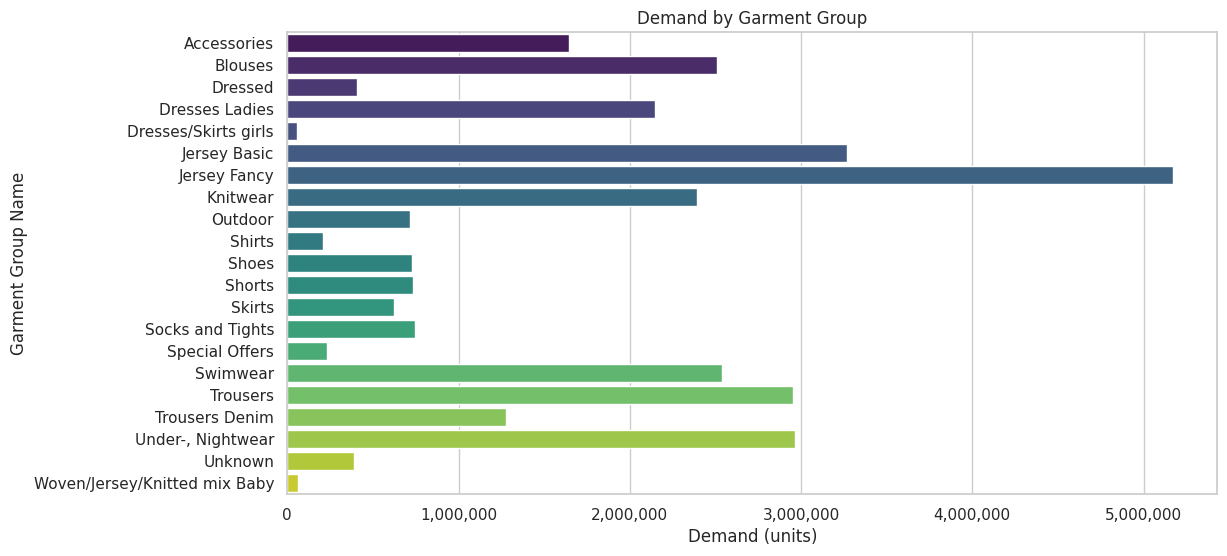

In [ ]:
#@title Demand by Garment Group

# Get the top 10 departments by demand
demand_by_category = merged_df.groupby(['garment_group_name']).size().reset_index(name='demand')

top_garment_group = demand_by_category.groupby('garment_group_name')['demand'].sum().nlargest(21).index

# Filter the DataFrame for the top 10 departments
top_garment_group_data = demand_by_category[demand_by_category['garment_group_name'].isin(top_garment_group)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 departments
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='garment_group_name', data=top_garment_group_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))


plt.title('Demand by Garment Group')
plt.xlabel('Demand (units)')
plt.ylabel('Garment Group Name')
plt.show()

In [ ]:
num_departments = df_article_info['department_name'].nunique()

print(f"Number of Departments: {num_departments}")

Number of Departments: 250


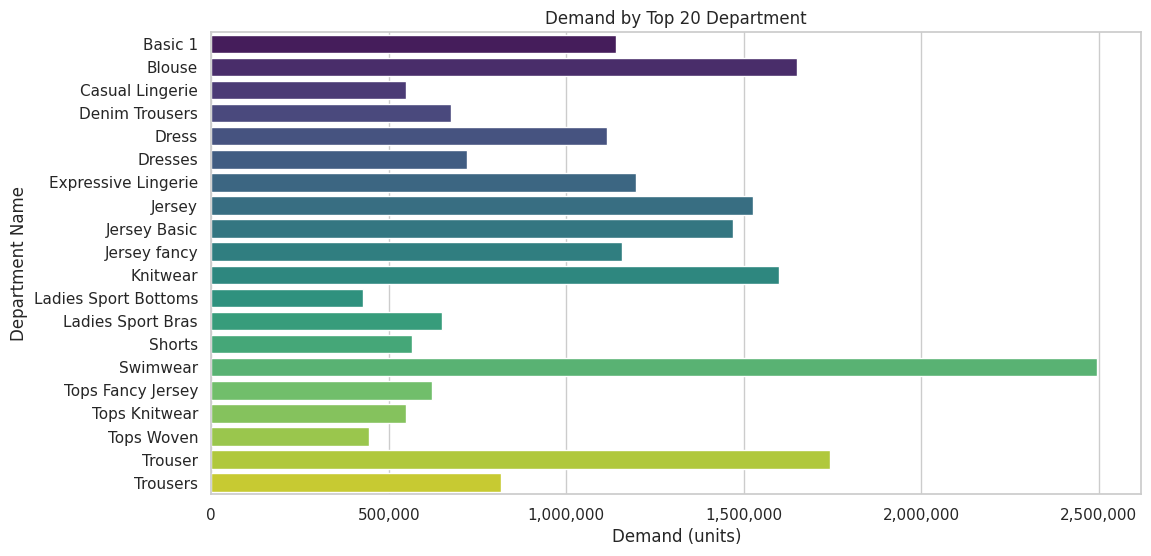

In [ ]:
#@title Demand by Department

# Get the top 10 departments by demand
demand_by_category = merged_df.groupby(['department_name']).size().reset_index(name='demand')

top_garment_group = demand_by_category.groupby('department_name')['demand'].sum().nlargest(20).index

# Filter the DataFrame for the top 10 departments
top_garment_group_data = demand_by_category[demand_by_category['department_name'].isin(top_garment_group)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 departments
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='department_name', data=top_garment_group_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))

plt.title('Demand by Top 20 Department')
plt.xlabel('Demand (units)')
plt.ylabel('Department Name')
plt.show()

In [ ]:
num_product_types = df_article_info['product_type_name'].nunique()

print(f"Number of Product Types: {num_product_types}")

Number of Product Types: 131


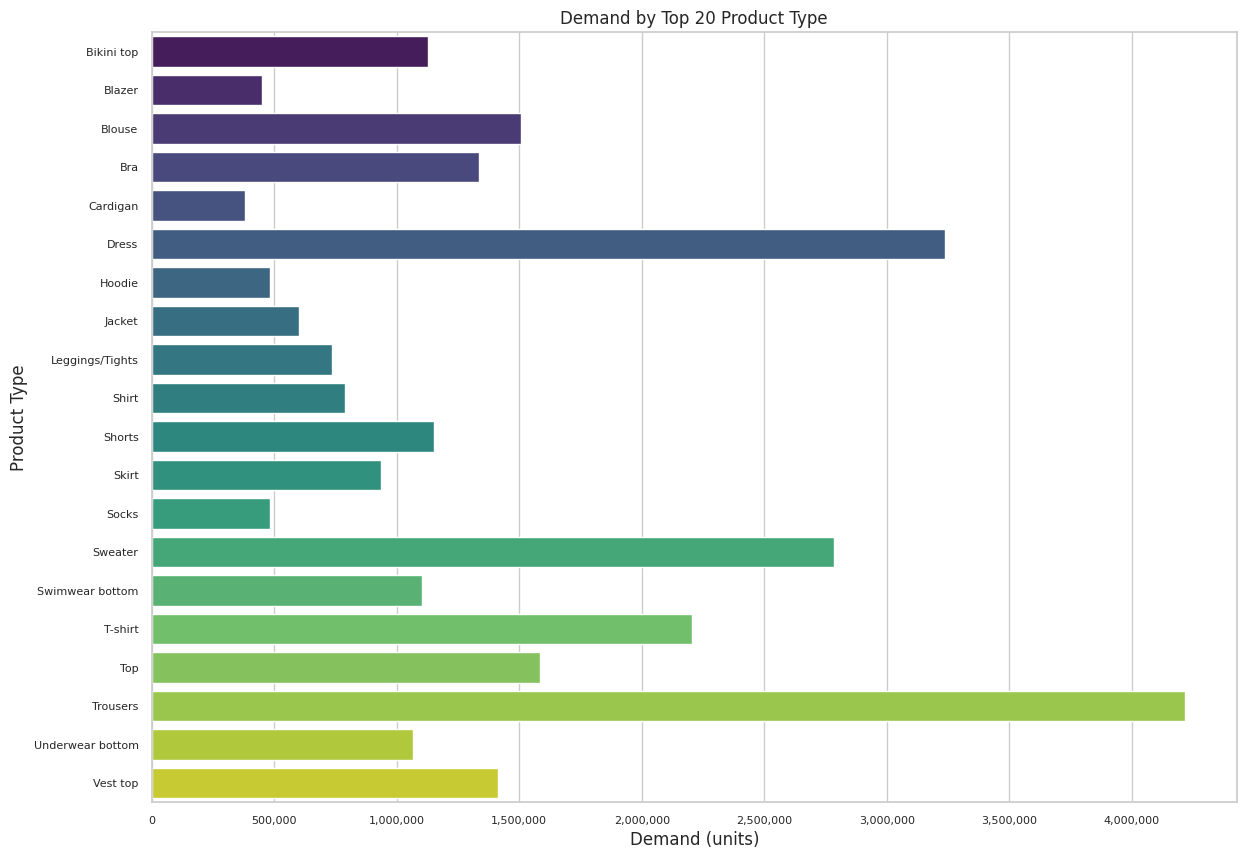

In [ ]:
#@title Demand by Product Type

# Get the top 10 product type by demand
demand_by_category = merged_df.groupby(['product_type_name']).size().reset_index(name='demand')

top_product_type = demand_by_category.groupby('product_type_name')['demand'].sum().nlargest(20).index

# Filter the DataFrame for the top 10 product type
top_product_type_data = demand_by_category[demand_by_category['product_type_name'].isin(top_product_type)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 product type
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='demand', y='product_type_name', data=top_product_type_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.title('Demand by Top 20 Product Type')
plt.xlabel('Demand (units)')
plt.ylabel('Product Type')
plt.show()

In [ ]:
num_product_groups = df_article_info['product_group_name'].nunique()

print(f"Number of Product Groups: {num_product_groups}")

Number of Product Groups: 19


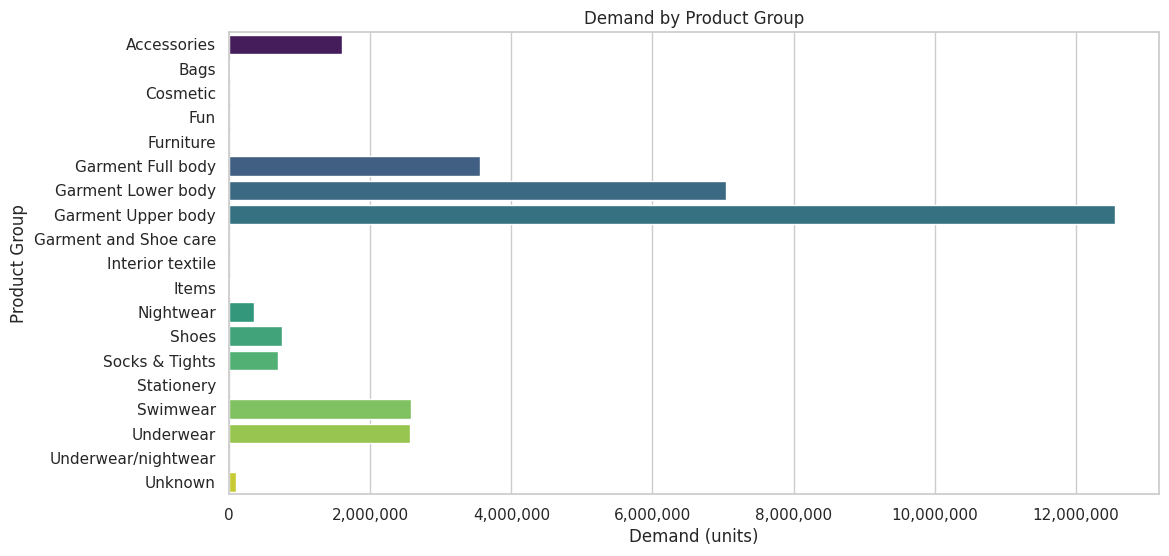

In [ ]:
#@title Demand by Product Group

# Get the top 10 product group by demand
demand_by_category = merged_df.groupby(['product_group_name']).size().reset_index(name='demand')

top_product_group = demand_by_category.groupby('product_group_name')['demand'].sum().nlargest(19).index

# Filter the DataFrame for the top 10 product group
top_product_group_data = demand_by_category[demand_by_category['product_group_name'].isin(top_product_group)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 product group
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='product_group_name', data=top_product_group_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))

plt.title('Demand by Product Group')
plt.xlabel('Demand (units)')
plt.ylabel('Product Group')
plt.show()

In [ ]:
# Assuming 'df_article_info' is your DataFrame
num_indexes = df_article_info['index_name'].nunique()

print(f"Number of Indexes: {num_indexes}")

Number of Indexes: 10


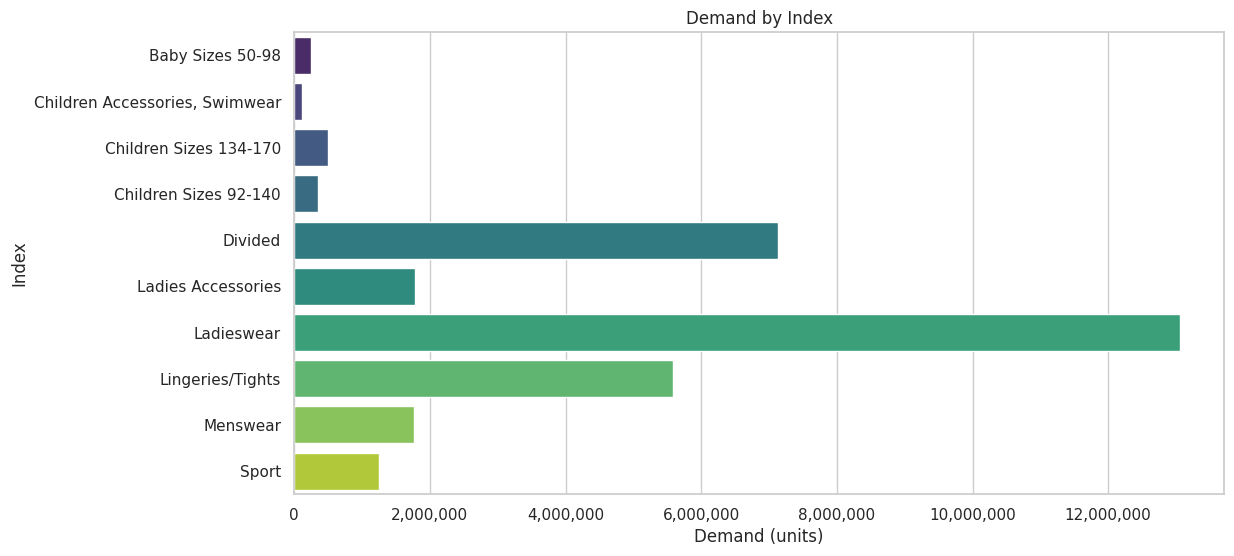

In [ ]:
#@title Demand by Index

demand_by_category = merged_df.groupby(['index_name']).size().reset_index(name='demand')

top_index = demand_by_category.groupby('index_name')['demand'].sum().nlargest(10).index

# Filter the DataFrame for the top 10 index
top_index_data = demand_by_category[demand_by_category['index_name'].isin(top_index)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 index
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='index_name', data=top_index_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))

plt.title('Demand by Index')
plt.xlabel('Demand (units)')
plt.ylabel('Index')
plt.show()

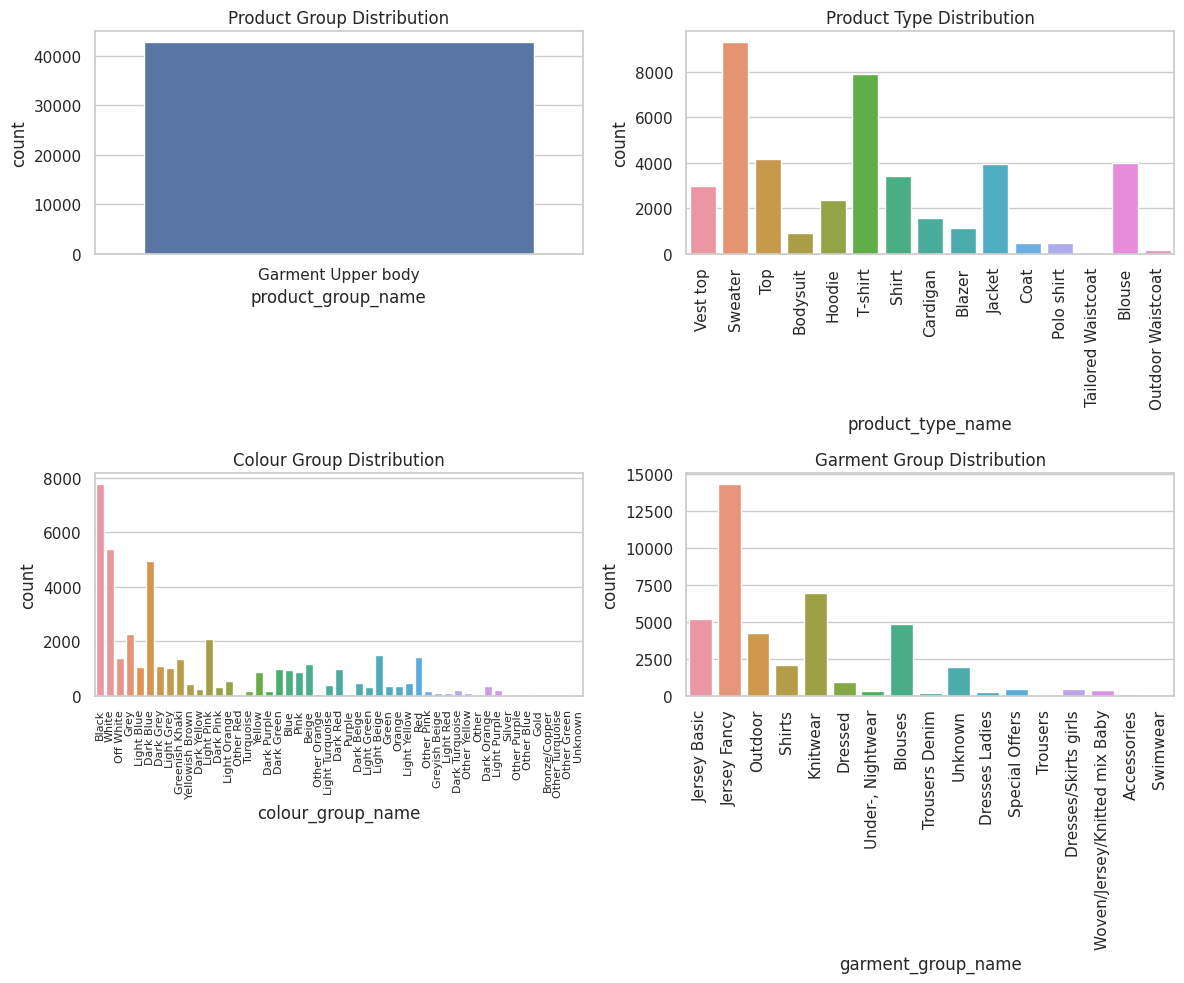

In [ ]:
#@title Summary visualization
# Set the style of the visualization (optional)
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

df_filtered = df_article_info[df_article_info['product_group_name'] == 'Garment Upper body']

# Bar chart for product_type_name
sns.countplot(x='product_group_name', data=df_filtered, ax=axes[0, 0])
axes[0, 0].set_title('Product Group Distribution')
axes[0, 0].tick_params(axis='x', rotation=0)  # Rotate x-axis labels for better visibility

# Bar chart for department_name
sns.countplot(x='product_type_name', data=df_filtered, ax=axes[0, 1])
axes[0, 1].set_title('Product Type Distribution')
axes[0, 1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

# Bar chart for colour_group_name
sns.countplot(x='colour_group_name', data=df_filtered, ax=axes[1, 0])
axes[1, 0].set_title('Colour Group Distribution')
axes[1, 0].tick_params(axis='x', rotation=90, labelsize=8)  # Rotate x-axis labels for better visibility


# Bar chart for garment_group_name
sns.countplot(x='garment_group_name', data=df_filtered, ax=axes[1, 1])
axes[1, 1].set_title('Garment Group Distribution')
axes[1, 1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

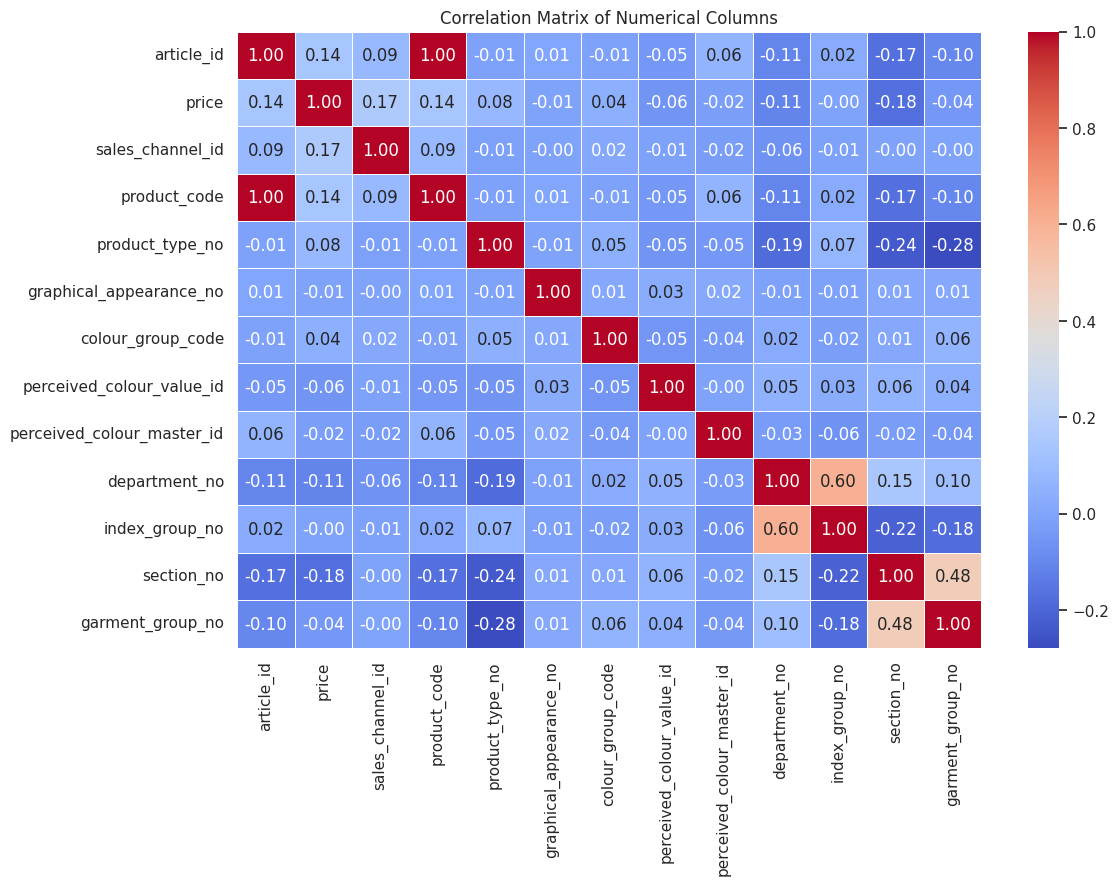

In [ ]:
#@title Correlation Matrix

# Considering only numerical columns for simplicity
numerical_columns = merged_df.select_dtypes(include=['int64', 'float64']).columns

# Calculate the correlation matrix
correlation_matrix = merged_df[numerical_columns].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [52]:
df_product_reviews.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


In [53]:
df_product_reviews.dtypes

Unnamed: 0                  int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [55]:
len(df_product_reviews)

23486

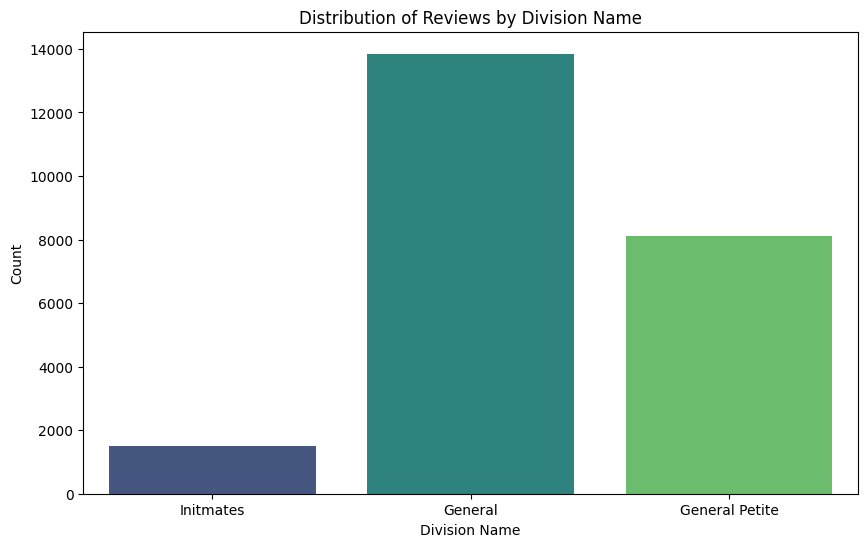

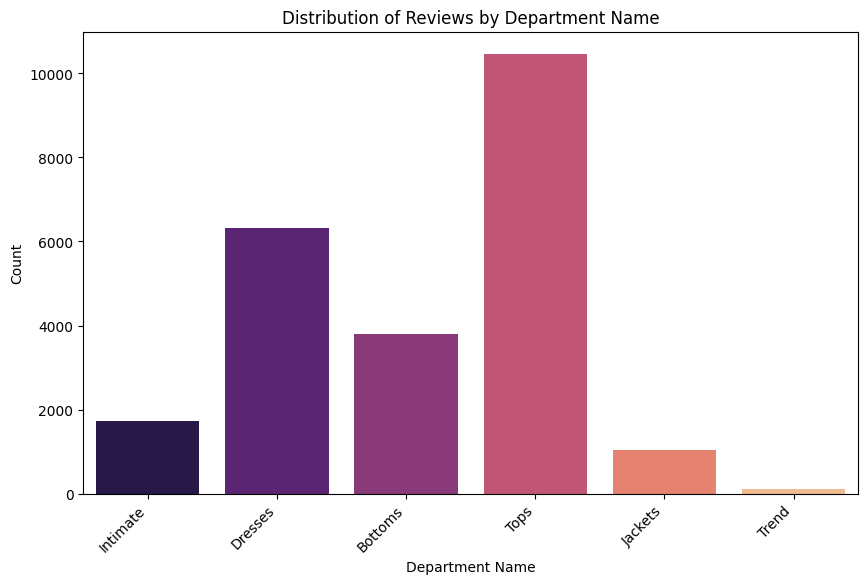

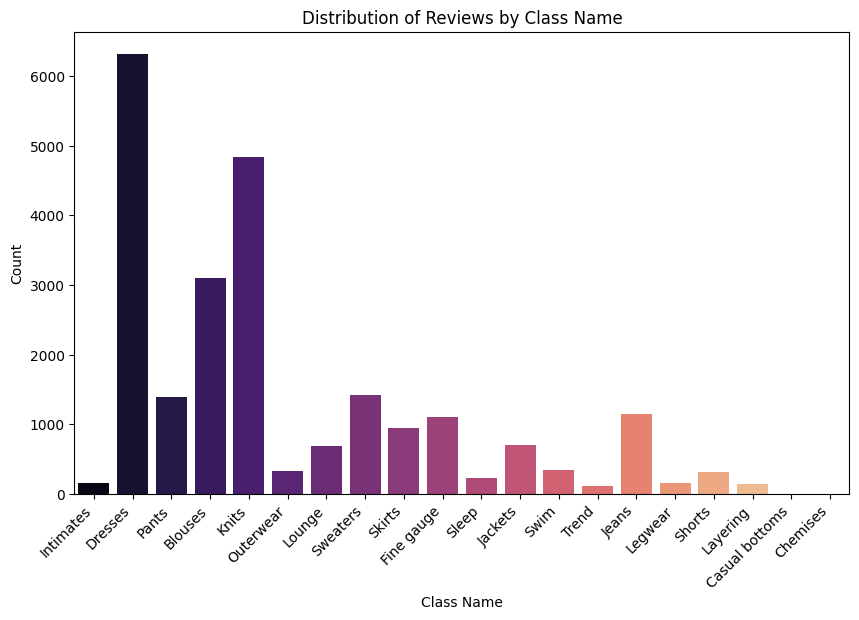

In [57]:
# Bar chart for Division Name
plt.figure(figsize=(10, 6))
sns.countplot(x='Division Name', data=df_product_reviews, palette='viridis')
plt.title('Distribution of Reviews by Division Name')
plt.xlabel('Division Name')
plt.ylabel('Count')
plt.show()

# Bar chart for Department Name
plt.figure(figsize=(10, 6))
sns.countplot(x='Department Name', data=df_product_reviews, palette='magma')
plt.title('Distribution of Reviews by Department Name')
plt.xlabel('Department Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

# Bar chart for Department Name
plt.figure(figsize=(10, 6))
sns.countplot(x='Class Name', data=df_product_reviews, palette='magma')
plt.title('Distribution of Reviews by Class Name')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [59]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import process

unique_product_types = merged_df['product_type_name'].unique()

# Create a DataFrame with unique product_type_names and their best matches
matches_data = {'product_type_name': unique_product_types}
matches_df = pd.DataFrame(matches_data)
matches_df['best_class_match'] = matches_df['product_type_name'].apply(lambda x: process.extractOne(x, df_product_reviews['Class Name'].unique())[0])

# Merge the matching results back into the main DataFrame
merged_df_reviews = pd.merge(merged_df, matches_df, on='product_type_name', how='left')

# Display the mapping results
mapping_results = merged_df_reviews[['product_type_name', 'best_class_match']]
print(mapping_results)

# LSTM Model (Time Series)

In [26]:
# Assuming 'merged_df' is your DataFrame
filtered_merged_df = merged_df[merged_df['garment_group_name'].str.contains("Jersey Fancy", case=False, na=False)]

In [27]:
filtered_merged_df.dtypes

t_dat                           datetime64[ns]
customer_id                             object
article_id                               int64
price                                  float64
sales_channel_id                         int64
product_code                             int64
prod_name                               object
product_type_no                          int64
product_type_name                       object
product_group_name                      object
graphical_appearance_no                  int64
graphical_appearance_name               object
colour_group_code                        int64
colour_group_name                       object
perceived_colour_value_id                int64
perceived_colour_value_name             object
perceived_colour_master_id               int64
perceived_colour_master_name            object
department_no                            int64
department_name                         object
index_code                              object
index_name   

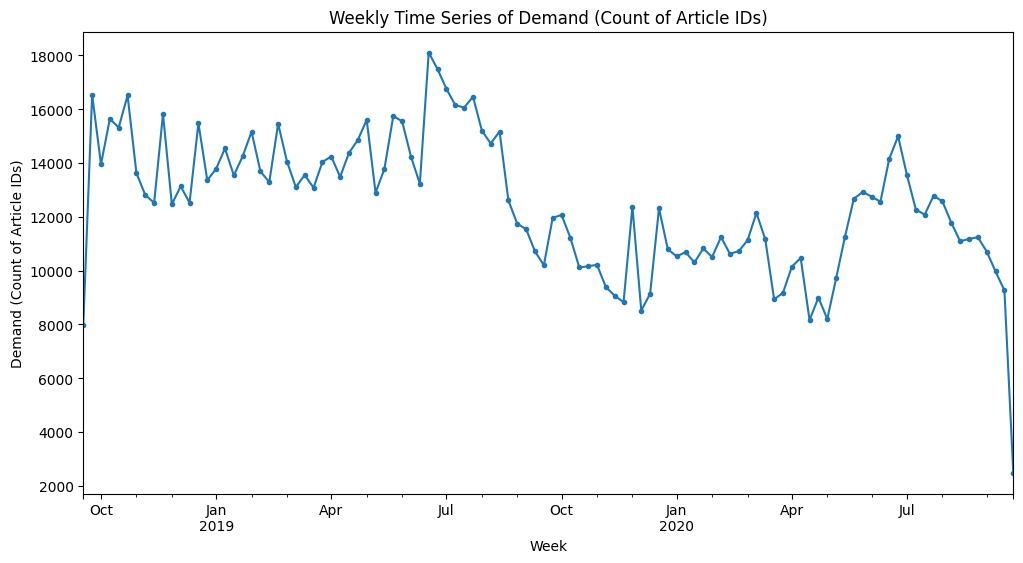

In [28]:
time_series_data = filtered_merged_df.groupby('t_dat')['article_id'].nunique()

# Resample the time series data to weekly frequency
time_series_data_weekly = time_series_data.resample('W').sum()

# Plot the time series
time_series_data_weekly.plot(style='.-', figsize=(12, 6), title='Weekly Time Series of Demand (Count of Article IDs)')
plt.xlabel('Week')
plt.ylabel('Demand (Count of Article IDs)')
plt.show()

In [29]:
time_series_data = filtered_merged_df.groupby('t_dat')['article_id'].nunique().reset_index()
time_series_data.columns = ['ds', 'y']  # Rename columns as required by Prophet

# Normalize the 'y' values
scaler = MinMaxScaler()
time_series_data['y_normalized'] = scaler.fit_transform(time_series_data[['y']])

# Create sequences of data with n_steps time steps
n_steps = 10
X, y = [], []
for i in range(len(time_series_data) - n_steps):
    X.append(time_series_data['y_normalized'].values[i:i+n_steps])
    y.append(time_series_data['y_normalized'].values[i+n_steps])

X, y = np.array(X), np.array(y)

# Reshape X to be 3D (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [30]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

In [32]:
# Fit the LSTM model on the training set
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
19/19 [==============================] - 1s 6ms/step - loss: 0.0949
Epoch 2/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0159
Epoch 3/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 4/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 5/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 6/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 7/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 8/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 9/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 10/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 11/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0100
Epoch 12/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0099
Epoch 13/50
19/19 [==============================

In [39]:
# Make predictions on the test set
predictions = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


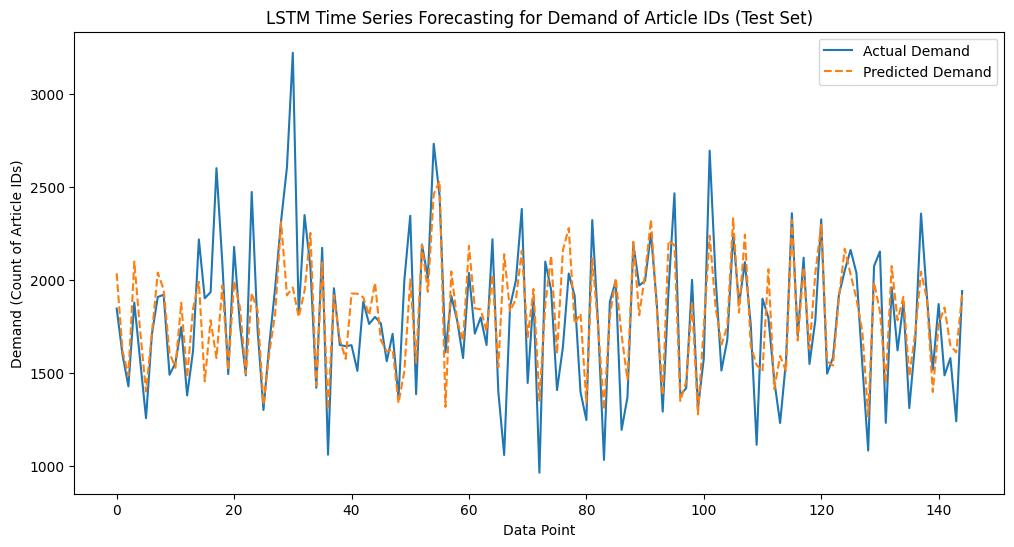

In [40]:
# Reverse the scaling for better interpretation of results
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Demand')b
plt.plot(predictions, label='Predicted Demand', linestyle='dashed')
plt.title('LSTM Time Series Forecasting for Demand of Article IDs (Test Set)')
plt.xlabel('Data Point')
plt.ylabel('Demand (Count of Article IDs)')
plt.legend()
plt.show()

# Prophet

In [41]:
from prophet import Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsocsqsyc/b0msks49.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsocsqsyc/z0syvfu5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=718', 'data', 'file=/tmp/tmpsocsqsyc/b0msks49.json', 'init=/tmp/tmpsocsqsyc/z0syvfu5.json', 'output', 'file=/tmp/tmpsocsqsyc/prophet_modeljpksihme/prophet_model-20231127030354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:03:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:03:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


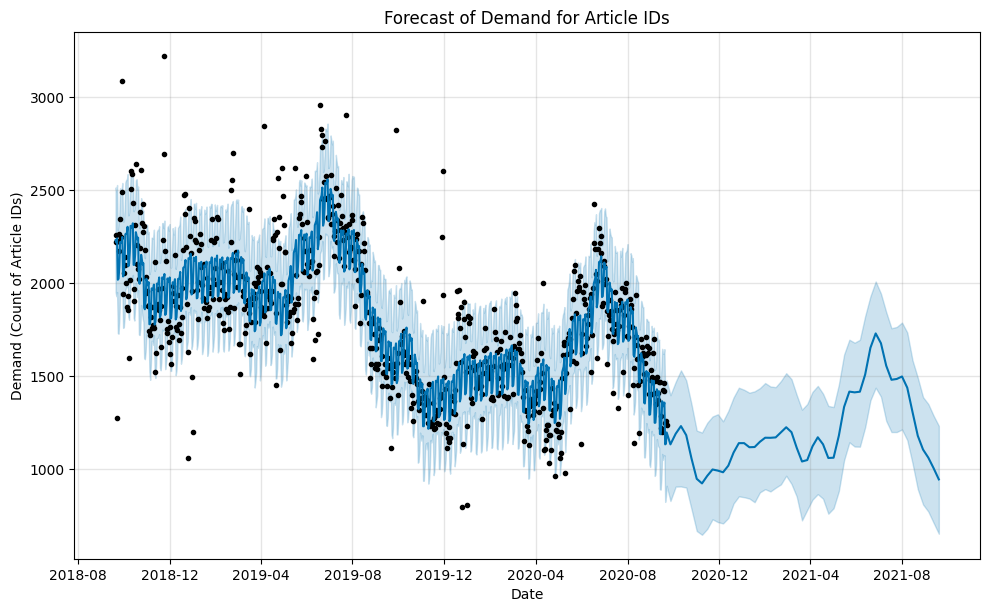

In [42]:
time_series_data = filtered_merged_df.groupby('t_dat')['article_id'].nunique().reset_index()
time_series_data.columns = ['ds', 'y']  # Rename columns as required by Prophet

# Initialize Prophet model
model = Prophet(yearly_seasonality=True)

# Fit the model
model.fit(time_series_data)

# Create a DataFrame with future dates for forecasting
future = model.make_future_dataframe(periods=52, freq='W')  # Adjust the number of future periods as needed

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of Demand for Article IDs')
plt.xlabel('Date')
plt.ylabel('Demand (Count of Article IDs)')
plt.show()